In [45]:
import mne
import yasa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import support_functions as sp
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import cohen_kappa_score, confusion_matrix, plot_roc_curve, RocCurveDisplay
from sklearn.multiclass import OneVsRestClassifier

In [2]:
# Let's load a nap recording, directly as an MNE Raw object
raw = mne.io.read_raw_edf('data/10/10.edf', preload=True, verbose=False)

raw.resample(100)
raw.filter(0.3, 45)

aux = raw.n_times/100

raw.crop(tmax=(aux - 30*30), include_tmax = False)


print('The channels are:', raw.ch_names)
print('The sampling frequency is:', raw.info['sfreq'])

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 47.50 Hz)
- Filter length: 1101 samples (11.010 sec)

The channels are: ['LOC-A2', 'ROC-A1', 'F3-A2', 'C3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8']
The sampling frequency is: 100.0


In [3]:
#Eliminamos las ultimas 30 epochs de 30 segundos ya que en el informe inicial creen conveniente hacerlo.
data = raw.get_data() * 1e6
print(data.shape)


(19, 2298000)


In [4]:
#raw.drop_channels(['ROC-A1', 'LOC-A2', 'EMG1-EMG2', 'EKG-R-EKG-L'])
chan = raw.ch_names
print(chan)

['LOC-A2', 'ROC-A1', 'F3-A2', 'C3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8']


In [5]:
sf = raw.info['sfreq']
sf

100.0

In [6]:
# Let's now load the human-scored hypnogram, where each value represents a 30-sec epoch.
hypno = np.loadtxt('data/10/10_1.txt', dtype=str)[0:-30]


#W=0
#N1=1
#N2=2
#N3=3
#R=5



In [7]:
#Con esta funcion homogeneizamos para que el numero 5(fase REM) sea 4.

def tagHomo(taglist):
    replacement = {
        "5":"4"
    }
    #out = np.array([replacement[i] for i in taglist])
    out = [int(4) if i == "5" else int(i) for i in taglist]
    return out
hypno = tagHomo(hypno)

<AxesSubplot:xlabel='Time [hrs]', ylabel='Stage'>

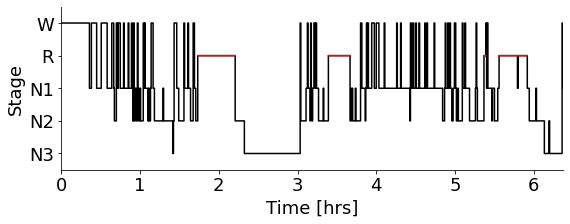

In [8]:
import yasa
yasa.plot_hypnogram(hypno)

In [9]:
yasa.sleep_statistics(hypno, sf_hyp=1/30)

{'TIB': 383.0,
 'SPT': 361.0,
 'WASO': 41.5,
 'TST': 319.5,
 'N1': 109.5,
 'N2': 86.5,
 'N3': 56.0,
 'REM': 67.5,
 'NREM': 252.0,
 'SOL': 22.0,
 'Lat_N1': 22.0,
 'Lat_N2': 41.0,
 'Lat_N3': 85.5,
 'Lat_REM': 104.5,
 '%N1': 34.27230046948357,
 '%N2': 27.073552425665103,
 '%N3': 17.52738654147105,
 '%REM': 21.12676056338028,
 '%NREM': 78.87323943661971,
 'SE': 83.42036553524804,
 'SME': 88.50415512465374}

In [10]:
counts, probs = yasa.transition_matrix(hypno)
probs.round(3)

To Stage,0,1,2,3,4
From Stage,,,,,
0,0.622,0.362,0.016,0.000,0.000
1,0.151,0.702,0.138,0.000,0.009
2,0.064,0.104,0.792,0.023,0.017
3,0.018,0.000,0.018,0.964,0.000
4,0.007,0.015,0.015,0.000,0.963


In [11]:
np.diag(probs.loc[2:, 2:]).mean().round(3)

0.906

In [12]:
hypno_up = yasa.hypno_upsample_to_data(hypno, sf_hypno=1/30, data=raw)
print(len(hypno_up))

2298000


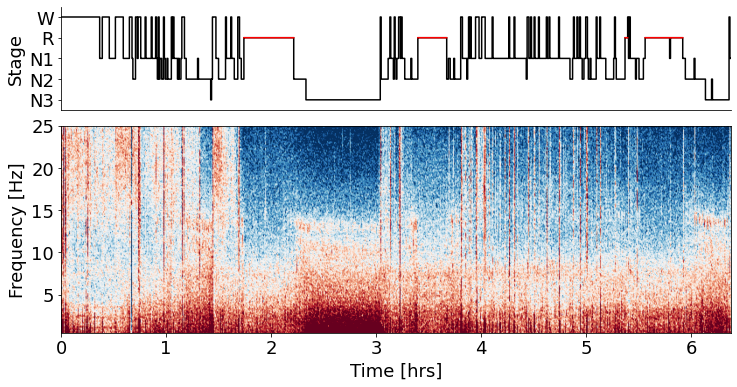

In [13]:
for i in chan:
    

    yasa.plot_spectrogram(data[chan.index("C4-A1")], sf, hypno_up);







In [14]:
yasa.bandpower(raw)

,Delta,Theta,Alpha,Sigma,Beta,Gamma,TotalAbsPow,FreqRes,Relative
Chan,,,,,,,,,
LOC-A2,0.661988,0.161387,0.079819,0.042341,0.048185,0.006279,6.142122e-01,0.25,True
ROC-A1,0.669519,0.146377,0.071976,0.046041,0.059709,0.006378,6.740071e-01,0.25,True
F3-A2,0.650919,0.187609,0.077910,0.037202,0.041038,0.005323,8.219186e-01,0.25,True
C3-A2,0.629692,0.196669,0.083395,0.041693,0.043063,0.005489,7.923983e-01,0.25,True
O1-A2,0.593149,0.212373,0.097914,0.046897,0.044450,0.005216,6.268346e-01,0.25,True
F4-A1,0.652027,0.173503,0.074792,0.041905,0.051580,0.006194,8.278975e-01,0.25,True
C4-A1,0.614791,0.183577,0.086471,0.049919,0.058257,0.006985,6.925439e-01,0.25,True
O2-A1,0.567931,0.206391,0.106910,0.055817,0.055852,0.007100,5.609031e-01,0.25,True
X1,0.000013,0.009354,0.046361,0.094395,0.525027,0.324850,4.992091e-02,0.25,True


In [15]:
yasa.bandpower(raw, relative=False, bands=[(1, 9, "Slow"), (9, 30, "Fast")])

,Slow,Fast,TotalAbsPow,FreqRes,Relative
Chan,,,,,
LOC-A2,3.767002e-01,8.756582e-02,4.642660e-01,0.25,False
ROC-A1,4.072298e-01,1.035475e-01,5.107773e-01,0.25,False
F3-A2,5.748390e-01,1.053496e-01,6.801886e-01,0.25,False
C3-A2,5.582585e-01,1.091130e-01,6.673715e-01,0.25,False
O1-A2,4.288837e-01,9.562382e-02,5.245075e-01,0.25,False
F4-A1,5.611232e-01,1.178359e-01,6.789591e-01,0.25,False
C4-A1,4.675233e-01,1.139211e-01,5.814444e-01,0.25,False
O2-A1,3.725944e-01,1.009946e-01,4.735890e-01,0.25,False
X1,8.293218e-04,3.287476e-02,3.370408e-02,0.25,False


In [16]:
bandpower = yasa.bandpower(raw, hypno=hypno_up, include=(2, 3, 4))

In [17]:
#fig = yasa.topoplot(bandpower.xs(3)['Delta'])

Detección de spindles

In [18]:
sp = yasa.spindles_detect(raw, hypno=hypno_up, include=(2, 3))

05-May-22 11:31:35 | ERROR | Wrong data amplitude for X3 (trimmed STD = 0.037). Unit of data MUST be uV! Channel will be skipped.
05-May-22 11:31:35 | ERROR | Wrong data amplitude for X4 (trimmed STD = 0.067). Unit of data MUST be uV! Channel will be skipped.
05-May-22 11:31:35 | ERROR | Wrong data amplitude for SaO2 (trimmed STD = 374003.809). Unit of data MUST be uV! Channel will be skipped.
05-May-22 11:32:29 | WARNING | No spindle were found in channel X2.
05-May-22 11:32:37 | WARNING | No spindle were found in channel X6.
05-May-22 11:32:53 | WARNING | No spindle were found in channel DC8.


In [19]:
sp.summary()

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Stage,Channel,IdxChannel
0,4464.31,4464.75,4465.13,0.82,3.430674,0.636995,-0.559366,0.323115,12.816071,10.0,0.530120,2,LOC-A2,0
1,4580.56,4580.98,4581.07,0.51,3.804446,0.831030,-0.264892,0.300588,12.790069,6.0,0.807692,2,LOC-A2,0
2,4664.59,4664.99,4665.18,0.59,3.214776,0.661100,-0.497890,0.274572,13.022407,8.0,0.666667,2,LOC-A2,0
3,4971.64,4972.14,4972.38,0.74,3.156897,0.719983,-0.232833,0.444876,12.638997,9.0,0.666667,2,LOC-A2,0
4,5025.75,5026.11,5026.28,0.53,2.292854,0.510270,-0.705726,0.279748,13.666000,6.0,0.666667,2,LOC-A2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2899,22905.73,22906.01,22906.30,0.57,332.545972,49.303372,3.072792,0.346524,12.681462,7.0,0.482759,3,X8,16
2900,22907.70,22907.99,22908.25,0.55,320.497739,49.609695,3.091069,0.322089,12.695495,7.0,0.517857,3,X8,16
2901,22909.64,22909.94,22910.30,0.66,314.732781,44.573097,2.752187,0.294813,12.618650,8.0,0.447761,3,X8,16
2902,22913.67,22914.01,22914.34,0.67,285.370233,38.708691,2.740637,0.358965,12.622731,8.0,0.500000,3,X8,16


The documentation of the function explains what each of these columns represent and how they’re calculated. Furthermore, by specifying the grp_chan and grp_stage parameters, we tell YASA to first average across channels and slep stages, respectively:

In [20]:
sp.summary(grp_chan=True, grp_stage=True)

Count   Density  Duration   Amplitude         RMS  AbsPower  \
Stage Channel                                                                
2     C3-A2      116  1.341040  0.809138    4.971893    1.081657 -0.004106   
      C4-A1       95  1.098266  0.838632    4.940109    1.044647 -0.082065   
      DC3        225  2.601156  0.640756  733.921617  103.501917  3.384413   
      F3-A2       45  0.520231  0.727111    4.731822    1.017056 -0.076357   
      F4-A1       43  0.497110  0.769302    4.954410    1.061945 -0.038107   
      LOC-A2       9  0.104046  0.606667    2.885209    0.639356 -0.458943   
      O1-A2      241  2.786127  0.985145    4.764562    1.031061 -0.021516   
      O2-A1      160  1.849711  0.888062    4.278793    0.900760 -0.178793   
      ROC-A1      17  0.196532  0.733529    4.178824    0.849604 -0.294056   
      X1           4  0.046243  0.612500    2.173360    0.356068 -1.201635   
      X5         132  1.526012  0.969545   17.706260    3.016197  0.336753   
      X7         544  6.289017  0.609301   72.403356   10.420360  1.565490   
      X8         573  6.624277  0.598394  358.315322   52.046296  2.997849   
3     C3-A2       27  0.482143  0.874074    5.487444    1.171289  0.024402   
      C4-A1       27  0.482143  0.679259    3.869574    0.884902 -0.201949   
      DC3        183  3.267857  0.623989  602.425700   84.477136  3.361302   
      F3-A2       10  0.178571  0.718000    4.982290    1.078674  0.003737   
      F4-A1        7  0.125000  0.721429    4.034281    0.905523 -0.168115   
      O1-A2       64  1.142857  0.970313    4.882313    1.059709 -0.005824   
      O2-A1       42  0.750000  0.812143    4.011886    0.883610 -0.199729   
      ROC-A1       2  0.035714  0.685000    2.605878    0.622843 -0.419129   
      X5          24  0.428571  0.922500    4.902131    0.899887 -0.217285   
      X7          89  1.589286  0.615618   87.000245   12.509568  1.689688   
      X8         225  4.017857  0.618578  529.443779   75.615599  3.213499   

               RelPower  Frequency  Oscillations  Symmetry  
Stage Channel                                               
2     C3-A2    0.353358  13.382679     10.387931  0.459925  
      C4-A1    0.330170  13.363878     10.631579  0.500674  
      DC3      0.318665  12.748304      7.871111  0.441306  
      F3-A2    0.321022  13.083859      9.022222  0.507761  
      F4-A1    0.315339  13.005510      9.488372  0.497159  
      LOC-A2   0.313515  13.116510      7.666667  0.587289  
      O1-A2    0.408574  13.546945     12.941909  0.488951  
      O2-A1    0.355454  13.428092     11.362500  0.493661  
      ROC-A1   0.271049  12.671196      8.588235  0.559013  
      X1       0.321629  13.978957      8.250000  0.567573  
      X5       0.321816  13.472438     11.590909  0.480343  
      X7       0.316306  12.718941      7.525735  0.502802  
      X8       0.316644  12.736141      7.333333  0.478104  
3     C3-A2    0.338894  13.448420     11.444444  0.504765  
      C4-A1    0.289712  13.423619      8.666667  0.424911  
      DC3      0.336393  12.783291      7.726776  0.350956  
      F3-A2    0.322967  13.302221      9.100000  0.561944  
      F4-A1    0.289474  13.084231      9.142857  0.467467  
      O1-A2    0.371810  13.585737     12.734375  0.440026  
      O2-A1    0.319810  13.506105     10.642857  0.477091  
      ROC-A1   0.298225  12.673535      8.500000  0.570464  
      X5       0.464800  13.373725     11.375000  0.609429  
      X7       0.312708  12.727905      7.595506  0.500794  
      X8       0.311804  12.782864      7.662222  0.458568

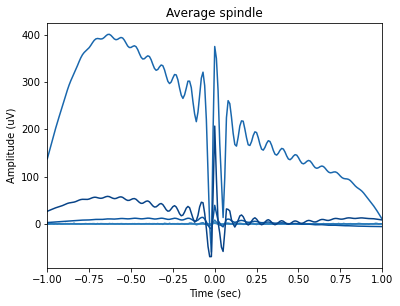

In [21]:
# Because of the large number of channels, we disable the 95%CI and legend
sp.plot_average(ci=None, legend=False, palette="Blues");

Slow-Waves

In [22]:
sw = yasa.sw_detect(raw, hypno=hypno_up, include=(2, 3))
sw.summary()

05-May-22 11:32:58 | ERROR | Wrong data amplitude for X3 (trimmed STD = 0.037). Unit of data MUST be uV! Channel will be skipped.
05-May-22 11:32:58 | ERROR | Wrong data amplitude for X4 (trimmed STD = 0.067). Unit of data MUST be uV! Channel will be skipped.
05-May-22 11:32:58 | ERROR | Wrong data amplitude for SaO2 (trimmed STD = 374003.809). Unit of data MUST be uV! Channel will be skipped.
05-May-22 11:33:02 | WARNING | No SW were found in channel LOC-A2.
05-May-22 11:33:02 | WARNING | No SW were found in channel ROC-A1.
05-May-22 11:33:02 | WARNING | No SW were found in channel F3-A2.
05-May-22 11:33:02 | WARNING | No SW were found in channel C3-A2.
05-May-22 11:33:02 | WARNING | No SW were found in channel O1-A2.
05-May-22 11:33:02 | WARNING | No SW were found in channel F4-A1.
05-May-22 11:33:02 | WARNING | No SW were found in channel C4-A1.
05-May-22 11:33:02 | WARNING | No SW were found in channel O2-A1.
05-May-22 11:33:03 | WARNING | No SW were found in channel X1.
05-May-22 

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Stage,Channel,IdxChannel
0,2480.41,2480.71,2480.96,2481.15,2481.73,1.32,-74.352895,34.004450,108.357345,433.429378,0.757576,2,DC3,14
1,2489.32,2489.57,2489.74,2489.85,2489.92,0.60,-83.029012,40.264546,123.293558,725.256222,1.666667,2,DC3,14
2,2506.40,2507.42,2507.55,2507.73,2507.85,1.45,-58.057204,103.545979,161.603182,1243.101403,0.689655,2,DC3,14
3,3577.00,3577.26,3577.49,3577.67,3578.33,1.33,-135.201591,74.860348,210.061939,913.312777,0.751880,2,DC3,14
4,3715.59,3716.84,3717.07,3717.25,3717.44,1.85,-174.819473,118.510419,293.329892,1275.347357,0.540541,2,DC3,14
5,4094.18,4094.46,4094.69,4095.33,4095.63,1.45,-42.179769,56.728375,98.908145,430.035412,0.689655,2,DC3,14
6,4101.91,4102.26,4102.58,4102.72,4102.89,0.98,-111.917131,21.880131,133.797262,418.116443,1.020408,2,DC3,14
7,4315.27,4315.46,4315.60,4315.70,4315.75,0.48,-61.666305,34.644965,96.311270,687.937645,2.083333,2,DC3,14
8,4862.34,4862.67,4863.48,4863.63,4863.75,1.41,-105.057587,10.675616,115.733204,142.880498,0.709220,2,DC3,14
9,4868.55,4868.86,4869.51,4869.73,4869.88,1.33,-142.172212,10.496623,152.668834,234.875130,0.751880,2,DC3,14


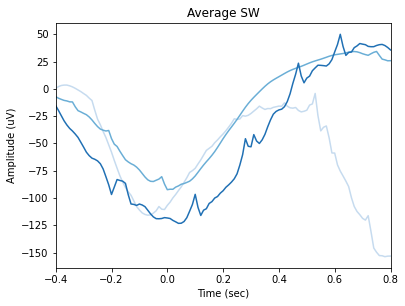

In [23]:
sw.plot_average(ci=None, legend=False, palette="Blues");

C:\Users\franc\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


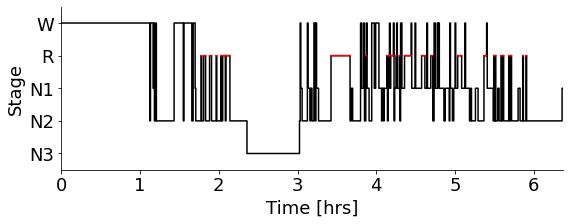

In [24]:
sls = yasa.SleepStaging(raw, eeg_name='C3-A2')
hypno_pred = sls.predict()  # Predict the sleep stages
hypno_pred = yasa.hypno_str_to_int(hypno_pred)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred);  # Plot

In [25]:
from sklearn.metrics import accuracy_score
print(f"The accuracy is {100 * accuracy_score(hypno, hypno_pred):.3f}%")

The accuracy is 61.880%


Separar en fases el data, es decir dividir por 3000 para separar cada 30 segundos.

In [30]:
mediastd = np.zeros([19*4, 766])

for i in np.arange(0,766):
    I = i*30
    for j in np.arange(0,19):
        mediastd[j, i] = np.mean(data[j, I:I+30])
        mediastd[j+19, i] = np.std(data[j, I:I+30])
        mediastd[j+19*2, i] = yasa.bandpower(data[j, I:I+30], sf=100).Beta
        mediastd[j+19*3, i] = yasa.bandpower(data[j, I:I+30], sf=100).Alpha
#Transponemos la matriz para que tenga las dimensiones (766,19)    
mediastd = np.array(mediastd).T

Cohen-kappa 0.5119512195121951


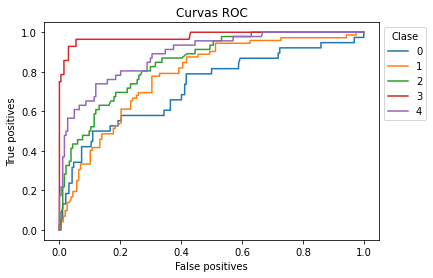

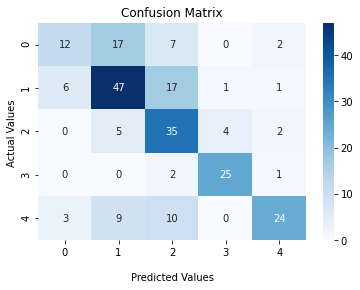

In [51]:
## Random forest (ensembles) ##

criterion = 'gini'
max_depth = None


Xtr, Xts, ytr, yts = train_test_split(mediastd, hypno, test_size=0.3, random_state=100)

# Train RF ensemble
rf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, criterion=criterion, random_state=100, max_depth=max_depth))
rf.fit(Xtr, ytr)
yb = rf.predict(Xts)

# Evaluate and compare results
print('Cohen-kappa',cohen_kappa_score(yts, yb))

Conf_matrix_RF = confusion_matrix(yts, yb)
Kappa_RF = cohen_kappa_score(yts, yb)

#Observamos como con el conjunto reducido de bandas, dejando solo 16 bandas, el ensemble funciona bastante bien con un
#cohen-kappa de ~0.74
tag_list = np.arange(0,5)
score = rf.predict_proba(Xts)
sp.draw_ROC(yts,score,tag_list)

sp.draw_ConfusionM(Conf_matrix_RF,tag_list)


Cohen-kappa 0.24320613578259642


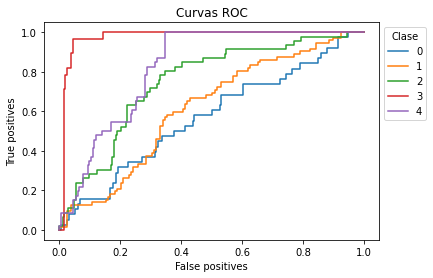

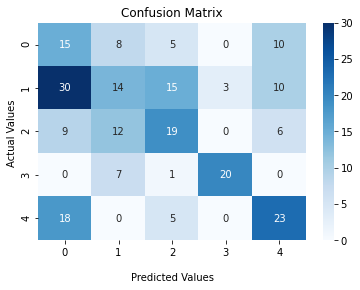

In [54]:
## Adaboosting (ensembles) ##

ada = AdaBoostClassifier(n_estimators=200, random_state=100)
ada.fit(Xtr, ytr)
yb = ada.predict(Xts)

# Evaluate and compare results
print('Cohen-kappa',cohen_kappa_score(yts, yb))

Conf_matrix_ada = confusion_matrix(yts, yb)
Kappa_RF = cohen_kappa_score(yts, yb)

tag_list = np.arange(0,5)
score = ada.predict_proba(Xts)
sp.draw_ROC(yts,score,tag_list)

sp.draw_ConfusionM(Conf_matrix_ada,tag_list)


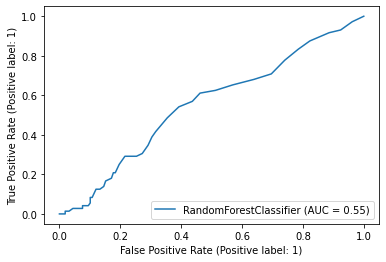

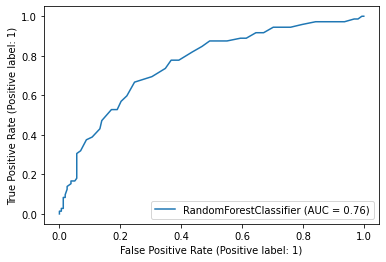

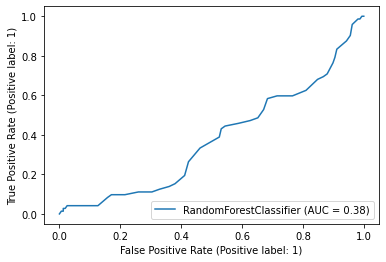

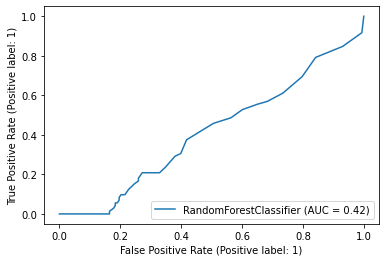

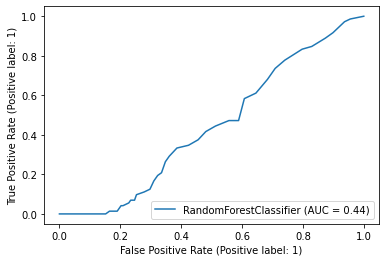

In [53]:
for model in rf.estimators_:
    
    RocCurveDisplay.from_estimator(model, Xts, yts)